# Import Libraries Used

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Utilities.plot import histvstarget, distribution

# Import and preprocess the data

Remember from the data exploration notebook that we now have three different data sets now, the original, one with PCA and one with attribute selection using BFE.

First lets take 10% of the data out to be used as a validation set and create the three different training-sets from the rest.

In [24]:
data = pd.read_csv('input/Train.csv')

In [25]:
data

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            8.0    133.0           72.0            NaN      NaN  32.9   
1            8.0    109.0           76.0           39.0    114.0  27.9   
2            4.0     99.0           76.0           15.0     51.0  23.2   
3           11.0    111.0           84.0           40.0      NaN  46.8   
4            1.0    119.0           86.0           39.0    220.0  45.6   
..           ...      ...            ...            ...      ...   ...   
686          2.0     89.0           90.0           30.0      NaN  33.5   
687          6.0      NaN           68.0           41.0      NaN  39.0   
688         12.0     88.0           74.0           40.0     54.0  35.3   
689          1.0    125.0           50.0           40.0    167.0  33.3   
690          3.0    170.0           64.0           37.0    225.0  34.5   

     DiabetesPedigreeFunction   Age  Outcome  
0                       0.270  39.0      1.0  
1                       0.640  31.0      1.0  
2                       0.223  21.0      0.0  
3                       0.925  45.0      1.0  
4                       0.808  29.0      1.0  
..                        ...   ...      ...  
686                     0.292  42.0      0.0  
687                     0.727  41.0      1.0  
688                     0.378  48.0      0.0  
689                     0.962  28.0      1.0  
690                     0.356  30.0      1.0  

[691 rows x 9 columns]

In [ ]:
from sklearn.utils import shuffle

X = data[data.columns[:-1]]
X
Y=data[data.columns[57:58]]
Y
print(type(Y))
X, Y = shuffle(X, Y)
print(X)
print(Y)

In [2]:
trainingdata_org = pd.read_csv('input/Train.csv')
cols = trainingdata_org.columns
trainingdata_org = trainingdata_org.dropna(axis=0)
ground_truth = trainingdata_org['Outcome']
trainingdata_org = trainingdata_org.drop(['Outcome'], axis=1)
x_train_un, x_val_un, y_train, y_val = train_test_split(trainingdata_org, ground_truth, 
                                                        test_size=0.1, random_state = 22)

meantrain = np.mean(x_train_un)
stdtrain = np.std(x_train_un)
standardize = lambda x: ((x - meantrain)/stdtrain)
invstandardize = lambda x: ((x*stdtrain + meantrain))

x_train = standardize(x_train_un)
x_val = standardize(x_val_un)

trainingdata = pd.DataFrame(np.hstack((x_train, y_train[:,np.newaxis])), columns = cols)
validationdata = pd.DataFrame(np.hstack((x_val, y_val[:,np.newaxis])), columns = cols)
trainingdata.head()

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.718725 -0.458883      -2.602080      -1.034028 -0.299577 -1.420212   
1    -0.718725  1.346738       0.887502       1.259767 -0.738378 -0.040065   
2    -1.026751  0.099218       1.204736      -0.208262 -0.299577 -0.808394   
3     1.437451 -1.607915      -0.064202       0.984511 -0.887404  0.315643   
4     1.437451 -0.754349       0.253032       0.984511  0.486951  0.899004   

   DiabetesPedigreeFunction       Age  Outcome  
0                 -0.357932 -0.475749      0.0  
1                 -0.546374  1.828328      0.0  
2                 -0.049572 -0.955766      0.0  
3                  0.492914  0.772293      0.0  
4                  0.367286  1.156306      1.0

In [3]:
# Dataset with PCA
import Utilities.mypca as PCA
pca = PCA.MyPCA()
pca.fit(x_train)
PCA_x_train = pca.fit_transform(5, x_train)
PCA_x_val = pca.fit_transform(5, x_val)
print(PCA_x_train.shape)

(315, 5)


/Users/sujataavirneni/ISYE-6870-1/ISYE6420-Diabetes-Classification-master/ISYE6420-Diabetes-Classification-master/Diabetes-Classification-master/Utilities/mypca.py:44: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for i in range(n_components)))  # stack num_components highest eigenvalue arrays.


In [4]:
BFE_cols = ["Glucose", "Pregnancies", "BMI", "SkinThickness", "Insulin", "BloodPressure"]
BFE_x_train = trainingdata[BFE_cols]
BFE_x_val = validationdata[BFE_cols]
print(BFE_x_train.shape)

(315, 6)


# Comparing models with K-fold cross validation using accuracy

Since our dataset is small the best way to approach it is probably by using shallow learners. 

Lets establish a baseline for the problem by using cross validation and a few classification models. If we use k-fold cross validation since our dataset is quite small a splitting of our data into to few folds could introduce a substantial bias. On the other hand if we chose k to large we will have a lot of variance. With the small data-set in the back of our head we chose k to be moderately large, 18.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
from sklearn.utils import shuffle

X = data[data.columns[:-1]]
X
Y=data[data.columns[57:58]]
Y
print(type(Y))
X, Y = shuffle(X, Y)
print(X)
print(Y)

In [6]:
LR = LogisticRegression()
GB = GaussianNB() # Gaussian NB since we have continous data.
KN = KNeighborsClassifier(n_neighbors=4, p = 2) # 4 Neighbors by euclidian distance.
DT_GINI = DecisionTreeClassifier(criterion="gini",max_depth=4) # Decision Tree with Gini impurity for quality of split
DT_IG = DecisionTreeClassifier(criterion="entropy",max_depth=4) # Information gain for quality of split
SV = SVC() # Support vector machine classifier.

modelnames = ["Logistic regression","Gaussian Naive Bayes", "4-Neighbors","Decisiontree Gini",
              "Decisiontree Information gain", "Support vector machine"]

models = zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV])
results_PCA = []
results_BFE = []
results = []

for name,model in models:
    kfold = KFold(n_splits=18)
    cv_result_PCA = cross_val_score(model, PCA_x_train, y_train, cv = kfold,scoring = "accuracy")
    cv_result_BFE = cross_val_score(model, BFE_x_train, y_train, cv = kfold,scoring = "accuracy")
    cv_result = cross_val_score(model, x_train, y_train, cv = kfold,scoring = "accuracy")
    results_PCA.append(cv_result_PCA)
    results_BFE.append(cv_result_BFE)
    results.append(cv_result)

print("PCA")
for name, res in zip(modelnames, results_PCA):
    print(name,res.mean())
print()
print("BFE")
for name, res in zip(modelnames, results_BFE):
    print(name,res.mean())
print()
print("All Data")
for name, res in zip(modelnames, results):
    print(name,res.mean())

PCA
Logistic regression 0.785039941902687
Gaussian Naive Bayes 0.7623456790123455
4-Neighbors 0.727850399419027
Decisiontree Gini 0.7558097312999273
Decisiontree Information gain 0.7269426289034133
Support vector machine 0.7494553376906317

BFE
Logistic regression 0.7659767610748003
Gaussian Naive Bayes 0.7716049382716049
4-Neighbors 0.733115468409586
Decisiontree Gini 0.7416485112563543
Decisiontree Information gain 0.7534495279593317
Support vector machine 0.7558097312999273

All Data
Logistic regression 0.7785039941902687
Gaussian Naive Bayes 0.7754175744371822
4-Neighbors 0.7367465504720407
Decisiontree Gini 0.7274872912127814
Decisiontree Information gain 0.7652505446623094
Support vector machine 0.7748729121278141


Text(0.5, 1.0, 'Raw data')

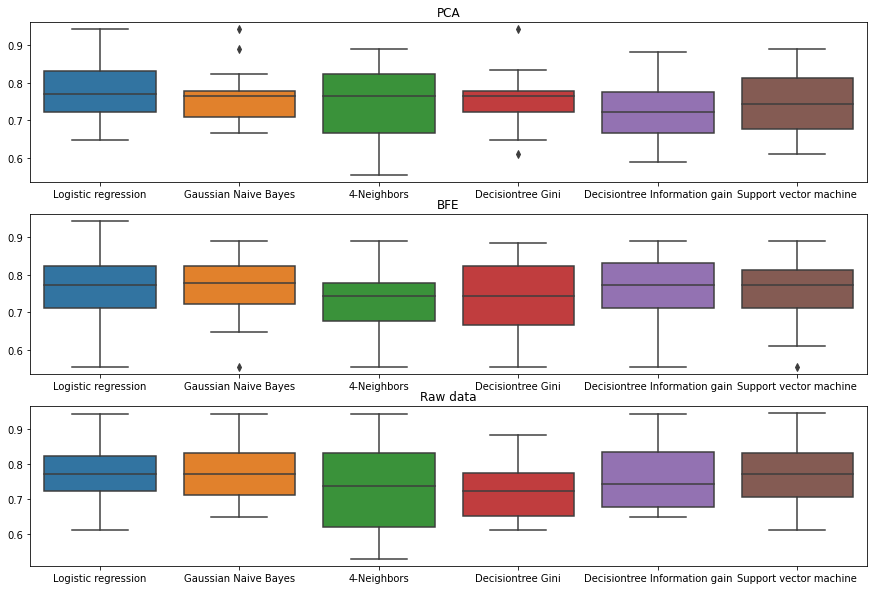

In [7]:
f, ax = plt.subplots(figsize=(15,10))
plt.subplot(3, 1, 1)
ax = sns.boxplot(data=results_PCA)
ax.set_title("PCA")
ax.set_xticklabels(modelnames)

plt.subplot(3, 1, 2)
ax = sns.boxplot(data=results_BFE)
ax.set_title("BFE")
ax.set_xticklabels(modelnames)

plt.subplot(3, 1, 3)
ax = sns.boxplot(data=results)
ax.set_xticklabels(modelnames)
ax.set_title("Raw data")
#plt.savefig('modelsvsdata.eps', format='eps', dpi=1000)

Still no sign of significantly better accuracy for any of the data sets, different models perform differently across the datasets. Logistic regression seems to be the best performing model. 

# Confusion Matrixes and validation data

Since k-fold-cross validation did not give us any clear information, lets have a look at the confusion matrixes and accuracy on the validation data for the different models.

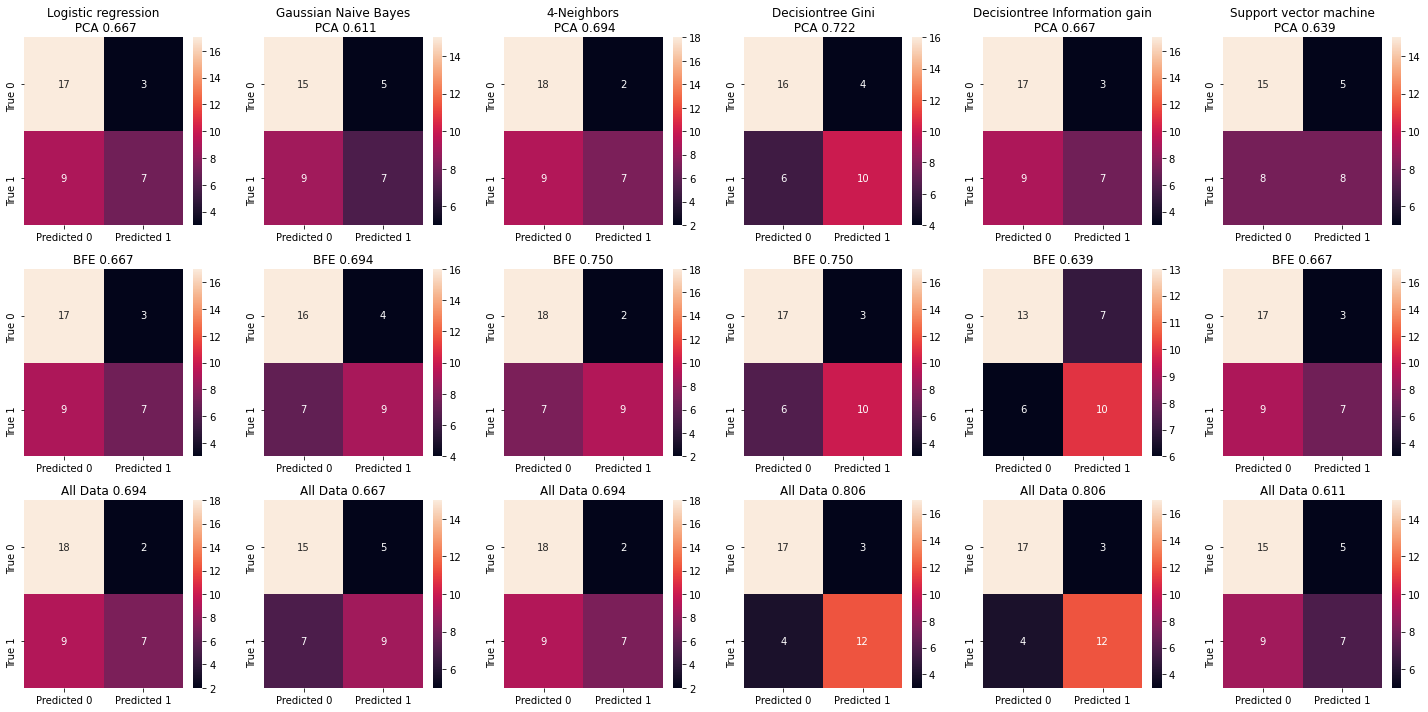

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

models = zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV])

i=1
xlabel = ["Predicted 0","Predicted 1"]
ylabel = ["True 0","True 1"]
plt.figure(figsize=(20, 10))

for name, model in models:
    model.fit(PCA_x_train, y_train)
    predictions=model.predict(PCA_x_val)
    conf_PCA = (confusion_matrix(y_val,predictions))
    plt.subplot(3, 6, i)
    sns.heatmap(conf_PCA, annot=True, xticklabels=xlabel, yticklabels=ylabel)    
    acc = (accuracy_score(y_val,predictions))
    plt.title(name + "\n PCA " + '{0:.{1}f}'.format(acc, 3))
    model.fit(BFE_x_train, y_train)
    predictions=model.predict(BFE_x_val)
    conf_BFE = (confusion_matrix(y_val,predictions))
    plt.subplot(3, 6, i+6)
    sns.heatmap(conf_BFE, annot=True, xticklabels=xlabel, yticklabels=ylabel)  
    acc = (accuracy_score(y_val,predictions))
    plt.title("BFE " + '{0:.{1}f}'.format(acc, 3))
    model.fit(x_train, y_train)
    predictions=model.predict(x_val)
    conf = (confusion_matrix(y_val,predictions))
    plt.subplot(3, 6, i+12)
    sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)  
    acc = (accuracy_score(y_val,predictions))
    plt.title("All Data " + '{0:.{1}f}'.format(acc, 3))
    i = i + 1

plt.tight_layout()
#plt.savefig('confusion.eps', format='eps', dpi=1000)

Look at that, apparently almost all models predict the unseen validation badly. The model that classifies the validation set significantly better is the decision trees. As we inspect the confusion matrix we note that most of the models have almost identical predictions when it comes to instances with true negative outcomes. Where they differ and where some of the the decision trees is superior is when we try to predict true positive outcomes. Many of the models are worse than random guessing. So why is this? It's called the False positive paradox. Basically since the majority of the instances has outcome not diabetes our models will favor predicting not diabetes. 

In [9]:
print("Number of training instances with outcome diabetes", np.count_nonzero(y_train))
print("Number of training instances with outcome not diabetes", len(y_train)-np.count_nonzero(y_train))

Number of training instances with outcome diabetes 102
Number of training instances with outcome not diabetes 213


This leads to another paradox, namely the accuracy paradox. Basically it means that because of the inbalance in outcomes predictive models with a given certain accuracy might have greater predictive capability than a model with higher accuracy. For example, a model with a 1:10 ratio between positive and negative outcomes, say 15 and 150. Predicting everything as negative gives us

In [10]:
example_train = [1 if i%10==0 else 0 for i in range(100)]
prediction = [0 for i in range(len(example_train))]
print("An accuracy when 10:1 ratio of", accuracy_score(example_train,prediction))

example_train = [1 if i < 102 else 0 for i in range(102+213)]
prediction = [0 for i in range(len(example_train))]
print("An accuracy when 2:1 ratio (our case) of", accuracy_score(example_train,prediction))

An accuracy when 10:1 ratio of 0.9
An accuracy when 2:1 ratio (our case) of 0.6761904761904762


Our completely useless models with zero predictive power have 90% respectively 68% accuracy. In our data the inbalance is not as sever but the moral remains. Hence we exchange accuracy as metric in favor of AUC - The area under the ROC (receiver operating characteristic) curve. The ROC curve is the true positive rate (TPR) against the false positive rate (FPR) at various thresholds/ranks for the instances. The area under the curve measures discrimination, the ability to correctly classify those with and without diabetes in our case. An simple interpretation is the following: consider if we randomly draw one person that has diabetes and one without, the person with high ranking (or low) should be the one with diabetes. The area under the curve is the percentage of randomly drawn pairs for which this is true.

In [11]:
from sklearn.metrics import roc_auc_score

print("PCA AUC")
for name, model in zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV]):
    model.fit(PCA_x_train, y_train)
    predictions=model.predict(PCA_x_val)
    roc = (roc_auc_score(y_val,predictions))
    print(name, roc)
    
print("\nBFE AUC")
for name, model in zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV]):
    model.fit(BFE_x_train, y_train)
    predictions=model.predict(BFE_x_val)
    roc = (roc_auc_score(y_val,predictions))
    print(name, roc)

print("\nAll data AUC")
for name, model in zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV]):
    model.fit(x_train, y_train)
    predictions=model.predict(x_val)
    roc = (roc_auc_score(y_val,predictions))
    print(name, roc)

PCA AUC
Logistic regression 0.64375
Gaussian Naive Bayes 0.59375
4-Neighbors 0.66875
Decisiontree Gini 0.7125
Decisiontree Information gain 0.64375
Support vector machine 0.625

BFE AUC
Logistic regression 0.64375
Gaussian Naive Bayes 0.68125
4-Neighbors 0.73125
Decisiontree Gini 0.7374999999999999
Decisiontree Information gain 0.6375000000000001
Support vector machine 0.64375

All data AUC
Logistic regression 0.66875
Gaussian Naive Bayes 0.65625
4-Neighbors 0.66875
Decisiontree Gini 0.8312499999999999
Decisiontree Information gain 0.7687499999999999
Support vector machine 0.59375


 Inspecting the confusion matrixes and AUC scores we note that the absolutely best model is the decision tree with gini impurity or entropy and using all the data, hence that is the model we'll move on with. This is good in the sense that interpretability is available, somethinng that might be important.

# Optimizing the decision tree

As familiar decision trees have high variance. As such we now look at the effect of increasing the maximum depth of the tree and at the same time inspecting the deviation of 100 trees at that depth. The maximum leaf nodes is fixed to avoid overfitting.

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning


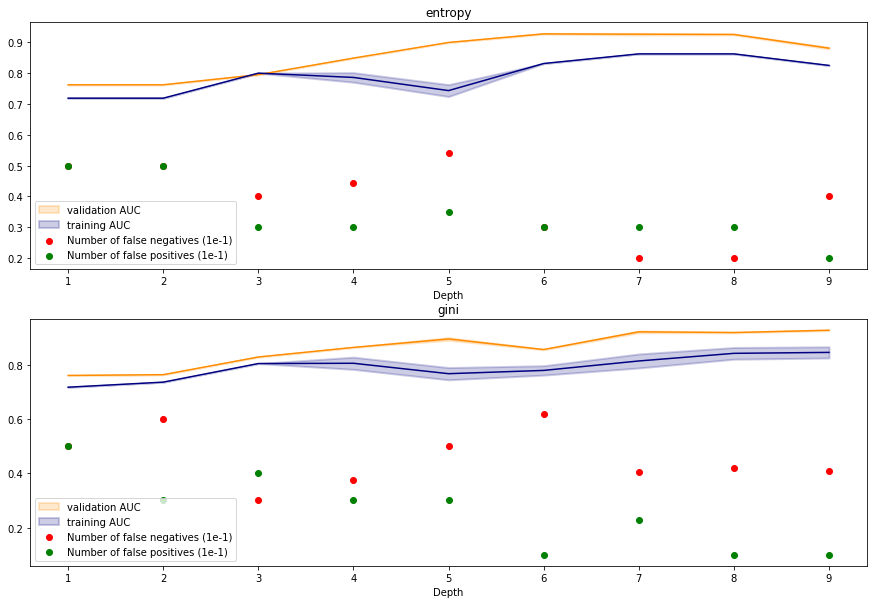

In [12]:
from sklearn.metrics import roc_auc_score
def exploredepth(cr, max_leaf_nodes):
    depth = np.arange(1,10,1)
    t = []
    v = []
    stdt = []
    stdv = []
    conf = []
    falpos = []
    falneg = []
    for i in depth:
        train_loss = []
        val_loss = []
        conf = []
        conf2 = []
        for j in range(1,100):
            model = DecisionTreeClassifier(criterion=cr, splitter='best', 
                                       max_depth=i, min_samples_split=2, min_samples_leaf=1, 
                                       min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                                       max_leaf_nodes=max_leaf_nodes, min_impurity_split=1e-07, 
                                           class_weight=None)
            model.fit(x_train, y_train)
            val_loss.append((roc_auc_score(y_val,model.predict(x_val))))
            train_loss.append((roc_auc_score(y_train,model.predict(x_train))))
            c = confusion_matrix(y_val,model.predict(x_val))
            conf.append(c[1][0])
            conf2.append(c[0][1])
        falpos.append(np.mean(conf))
        falneg.append(np.mean(conf2))
        t.append(np.mean(train_loss))
        stdt.append(np.std(train_loss))
        v.append(np.mean(val_loss))
        stdv.append(np.std(val_loss))
    lw = 2
    plt.plot(depth,t,color="darkorange")
    tp =plt.fill_between(depth, np.array(t) - np.array(stdt),
                     np.array(t) + np.array(stdt), alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(depth,v,color = "navy")
    vp = plt.fill_between(depth, np.array(v) - np.array(stdv),
                     np.array(v) + np.array(stdv), alpha=0.2,
                     color="navy", lw=lw)
    fp = plt.scatter(depth, np.array(falpos)/10.0, color="red")
    fn = plt.scatter(depth, np.array(falneg)/10.0, color="green")
    plt.legend((tp,vp,fp,fn),
               ['validation AUC','training AUC','Number of false negatives (1e-1)','Number of false positives (1e-1)']
               , loc='lower left')
    plt.xlabel('Depth')

plt.figure(figsize=(15, 10))
plt.subplot(2,1,1)
plt.title('entropy')
exploredepth('entropy', 25)

plt.subplot(2,1,2)
plt.title('gini')
exploredepth('gini', 25)
#plt.savefig('xploredepth.eps', format='eps', dpi=1000)

The plot does not imply any overfitting, by inspection the best model is the decision tree with entropy criterion using a leaf node bound of 25, and depth bound of 6. 

## Parameter search

To do a more rigorus parameter search we're gonna search an selected subset of the parameters.

In [13]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import zero_one_loss, f1_score
from Utilities.utils import gridsearch

model = DecisionTreeClassifier() # Our model
param_grid = {"max_depth": np.arange(2,8,1), # Maximum depth of tree
              "max_features": np.arange(3,8,1), # Number of features to consider when looking for the best split
              "max_leaf_nodes": np.arange(4,27,1), # Maximum number of leaves in our tree.
              "criterion": ["gini", "entropy"], # Splitting criteria
              "class_weight": [None, 'balanced',{0: 1.105, 1: 1.15}] # Weights associated with classes.
            }

metric = roc_auc_score # Metric to use
tiebreaker = zero_one_loss # Tie breaker metric.
n_best_grids = 10 # 5 best grids

best_score, best_grid, tiebreaker = gridsearch(model, x_train, y_train, x_val, y_val, param_grid, metric, 
                                               n_best_grids, loss=False, tiebreaker=tiebreaker)

        
for a,t,g in zip(best_score, tiebreaker, best_grid):
    print("AUC:",a) 
    print("Tie",t)
    print("Grid:",g)

AUC: 0.8875
Tie 0.11111111111111116
Grid: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 6, 'max_leaf_nodes': 18}
AUC: 0.8875
Tie 0.13888888888888884
Grid: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 5, 'max_leaf_nodes': 22}
AUC: 0.8625
Tie 0.13888888888888884
Grid: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 6, 'max_leaf_nodes': 24}
AUC: 0.8625
Tie 0.13888888888888884
Grid: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 7, 'max_leaf_nodes': 23}
AUC: 0.8625
Tie 0.13888888888888884
Grid: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 6, 'max_leaf_nodes': 17}
AUC: 0.8625
Tie 0.13888888888888884
Grid: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 7, 'max_leaf_nodes': 19}
AUC: 0.8625
Tie 0.13888888888888884
Grid: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_fe

[[13  7]
 [ 5 11]]


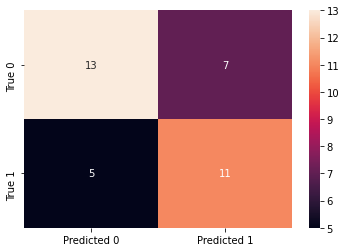

In [14]:
model.set_params(**best_grid[0])
model.fit(x_train,y_train)
c = confusion_matrix(y_val,model.predict(x_val))
sns.heatmap(c, annot=True, xticklabels=xlabel, yticklabels=ylabel) 
print(c)

This seems like a good result and we could naively choose this single tree, or any of the top 10 combinations as they have the same error, as our model. The problem is that every time we run the parameter search another combination of parameters will be the best tree because of the intrinsic variance of decision trees, additionally these trees will have a really good error as well because of the natural low bias of decision trees. Remember that the trees are tuned to the validation set and might, probably wont, generalize good to new data.

But there is some pattern to what sort of combinations work for the problem. For the entropy criterion trees the best performing ones the maximum depth is between 5 and 7, the maximum number of leaves between 22 and 26, the maximum number of features to consider on each split around 7 and using balanced weighting for the classes. The balanced weighting adjust the weights for the classes inversely proportional to class frequencies, basically counteracting the false positive hypothesis mentioned earlier. 

For the gini criterion trees the best performing ones the maximum depth is around 7, the maximum number of leaves varies a lot but tend to approach higher values (≈25), the maximum number of features to consider on each split around 7 and using the proposed weighting for the classes.

To decrease variance and try to make our model to generalize we use need to use an ensemble. The first that comes to mind is trying Bootstrap aggregating or a random forest. It should theoretically provide the stability we need and reduces variance.

# Ensembles

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

0.7125


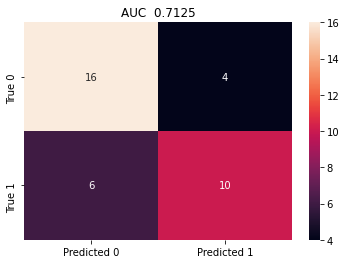

In [15]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
base = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                       max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                                       min_weight_fraction_leaf=0.0, max_features=7, random_state=None, 
                                       max_leaf_nodes=22, min_impurity_split=1e-07, 
                                           class_weight='balanced')

model = BaggingClassifier(base_estimator=base, n_estimators=100, max_samples=1.0, max_features=1.0, 
                  bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, 
                  n_jobs=1, random_state=None, verbose=0)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
conf = (confusion_matrix(y_val,predictions))
auc = (roc_auc_score(y_val,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)
plt.title("AUC  " + str(auc))
print(auc)
#plt.savefig('Bagging.eps', format='eps', dpi=1000)

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

0.71875


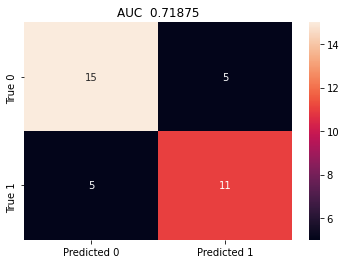

In [16]:
model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5, 
                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                       max_features='auto', max_leaf_nodes=22, min_impurity_split=1e-07, 
                       bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
                       warm_start=False, class_weight='balanced')
model.fit(x_train, y_train)
predictions = model.predict(x_val)
conf = (confusion_matrix(y_val,predictions))
auc = (roc_auc_score(y_val,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)
plt.title("AUC  " + str(auc))
print(auc)
#plt.savefig('randfor.eps', format='eps', dpi=1000)

The ensembles seems to provide stability and decrease the variance run to run. However they seem to introduce some bias. Looking back at when we compared entropy and gini criterion and looked at the effect of the depth and variance. Remember that the gini trees generally had few false positives while entropy trees had few false negatives. An viable hypothesis might be that the two complement each other, and because we in the ensembles above only use the one or the other. To test the hypothesis we're gonna try an VotingClassifier using the parameters search result we acquired above. 

The voting classifier consists of a 5:4 ratio of entropy and gini trees since the gini trees showed less potential in the grid search. The classification is done using a majority vote rule.

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

0.825
0.9074150787075393


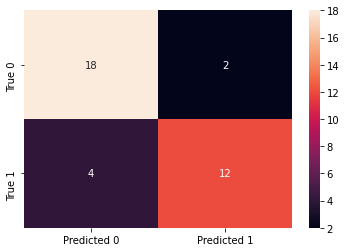

In [17]:
from sklearn.ensemble import VotingClassifier
mods = []
for i in range(1,100): # 100 Trees provides low variance.
    # A parameter combination that were sucessfull for entropy trees.
    mods.append((str(i),DecisionTreeClassifier(criterion='entropy', splitter='best', 
                               max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                               max_leaf_nodes=22, min_impurity_split=1e-07, class_weight='balanced')))
    if(i < 80):
        # A parameter combination that were sucessfull for gini trees.
        mods.append((str(i)+"gi",DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=7, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                               max_leaf_nodes=25, min_impurity_split=1e-07, 
                                                        class_weight={0: 1.105, 1: 1.15})))
model = VotingClassifier(estimators=mods, voting='hard', n_jobs=1)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
conf = (confusion_matrix(y_val,predictions))
auc = (roc_auc_score(y_val,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)
print(auc)
print((roc_auc_score(y_train,model.predict(x_train))))

The hypothesis might be true, this is a really good separation and a AUC of nearly 89 for the validation set and 93 for the training set. Thats not a gigantic difference and hopefully the constraints on the trees have prevented the model from overfitting on the training data.

# Pipeline

Before giving the test set a go we train our model on the entire training dataset with some imputing. We also put it into a pipeline to automate the work-flow.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X = pd.read_csv('input/Train.csv')
X
Y = X['Outcome']
X = X.drop(["Outcome"], axis=1)

model = VotingClassifier(estimators=mods, voting='hard', n_jobs=1)

In [ ]:
X = X[~X.Pregnancies.isna()]
X = X[~X.Glucose.isna()]
X = X[~X.BloodPressure.isna()]
X = X[~X.SkinThickness.isna()]
X = X[~X.Insulin.isna()]
X = X[~X.BMI.isna()]
X = X[~X.DiabetesPedigreeFunction.isna()]
X = X[~X.Age.isna()]
X = X[~X.Outcome.isna()]
X

In [ ]:
X=X.dropna()
Y=Y.dropna()
X



In [27]:
#missing_values='NaN'
pipeline = Pipeline([("imputer", SimpleImputer(missing_values = np.nan,
                                          strategy="mean"
                                          )),
                      ("standardizer", StandardScaler()),
                      ("VotingClassifier", model)])

In [20]:
X

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            8.0    133.0           72.0            NaN      NaN  32.9   
1            8.0    109.0           76.0           39.0    114.0  27.9   
2            4.0     99.0           76.0           15.0     51.0  23.2   
3           11.0    111.0           84.0           40.0      NaN  46.8   
4            1.0    119.0           86.0           39.0    220.0  45.6   
..           ...      ...            ...            ...      ...   ...   
686          2.0     89.0           90.0           30.0      NaN  33.5   
687          6.0      NaN           68.0           41.0      NaN  39.0   
688         12.0     88.0           74.0           40.0     54.0  35.3   
689          1.0    125.0           50.0           40.0    167.0  33.3   
690          3.0    170.0           64.0           37.0    225.0  34.5   

     DiabetesPedigreeFunction   Age  
0                       0.270  39.0  
1                       0.640  31.0  
2                       0.223  21.0  
3                       0.925  45.0  
4                       0.808  29.0  
..                        ...   ...  
686                     0.292  42.0  
687                     0.727  41.0  
688                     0.378  48.0  
689                     0.962  28.0  
690                     0.356  30.0  

[691 rows x 8 columns]

In [28]:
pipeline.fit(X,Y)

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning
/Users/sujataavirneni/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarnin

Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardizer', StandardScaler()),
                ('VotingClassifier',
                 VotingClassifier(estimators=[('1',
                                               DecisionTreeClassifier(class_weight='balanced',
                                                                      criterion='entropy',
                                                                      max_depth=5,
                                                                      max_leaf_nodes=22,
                                                                      min_impurity_split=1e-07)),
                                              ('1gi',
                                               DecisionTreeClassifier(class_weight={0: 1.105,
                                                                                    1: 1.15},
                                                                      max_depth=7,
                                

In [29]:
X

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            8.0    133.0           72.0            NaN      NaN  32.9   
1            8.0    109.0           76.0           39.0    114.0  27.9   
2            4.0     99.0           76.0           15.0     51.0  23.2   
3           11.0    111.0           84.0           40.0      NaN  46.8   
4            1.0    119.0           86.0           39.0    220.0  45.6   
..           ...      ...            ...            ...      ...   ...   
686          2.0     89.0           90.0           30.0      NaN  33.5   
687          6.0      NaN           68.0           41.0      NaN  39.0   
688         12.0     88.0           74.0           40.0     54.0  35.3   
689          1.0    125.0           50.0           40.0    167.0  33.3   
690          3.0    170.0           64.0           37.0    225.0  34.5   

     DiabetesPedigreeFunction   Age  
0                       0.270  39.0  
1                       0.640  31.0  
2                       0.223  21.0  
3                       0.925  45.0  
4                       0.808  29.0  
..                        ...   ...  
686                     0.292  42.0  
687                     0.727  41.0  
688                     0.378  48.0  
689                     0.962  28.0  
690                     0.356  30.0  

[691 rows x 8 columns]

In [32]:
X=X.fillna(X.mean())
X

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0            8.0  133.000000           72.0      29.176591  156.926346  32.9   
1            8.0  109.000000           76.0      39.000000  114.000000  27.9   
2            4.0   99.000000           76.0      15.000000   51.000000  23.2   
3           11.0  111.000000           84.0      40.000000  156.926346  46.8   
4            1.0  119.000000           86.0      39.000000  220.000000  45.6   
..           ...         ...            ...            ...         ...   ...   
686          2.0   89.000000           90.0      30.000000  156.926346  33.5   
687          6.0  122.260933           68.0      41.000000  156.926346  39.0   
688         12.0   88.000000           74.0      40.000000   54.000000  35.3   
689          1.0  125.000000           50.0      40.000000  167.000000  33.3   
690          3.0  170.000000           64.0      37.000000  225.000000  34.5   

     DiabetesPedigreeFunction   Age  
0                       0.270  39.0  
1                       0.640  31.0  
2                       0.223  21.0  
3                       0.925  45.0  
4                       0.808  29.0  
..                        ...   ...  
686                     0.292  42.0  
687                     0.727  41.0  
688                     0.378  48.0  
689                     0.962  28.0  
690                     0.356  30.0  

[691 rows x 8 columns]

In [33]:
dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X,Y)
print(dt_clf)

DecisionTreeClassifier()


In [34]:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, random_state=None, splitter='best')

DecisionTreeClassifier()

[Text(165.36618713733074, 211.04470588235293, 'X[1] <= 127.5\ngini = 0.456\nsamples = 691\nvalue = [448, 243]'),
 Text(79.14668762088975, 198.25411764705882, 'X[7] <= 28.5\ngini = 0.313\nsamples = 432\nvalue = [348, 84]'),
 Text(40.95957446808511, 185.4635294117647, 'X[5] <= 45.4\ngini = 0.166\nsamples = 241\nvalue = [219, 22]'),
 Text(28.16982591876209, 172.6729411764706, 'X[5] <= 30.95\ngini = 0.147\nsamples = 237\nvalue = [218, 19]'),
 Text(10.361315280464217, 159.88235294117646, 'X[0] <= 7.0\ngini = 0.031\nsamples = 129\nvalue = [127, 2]'),
 Text(7.770986460348162, 147.09176470588235, 'X[4] <= 48.5\ngini = 0.016\nsamples = 128\nvalue = [127, 1]'),
 Text(5.180657640232108, 134.30117647058825, 'X[4] <= 47.0\ngini = 0.117\nsamples = 16\nvalue = [15, 1]'),
 Text(2.590328820116054, 121.51058823529411, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]'),
 Text(7.770986460348162, 121.51058823529411, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(10.361315280464217, 134.30117647058825, 'gini =

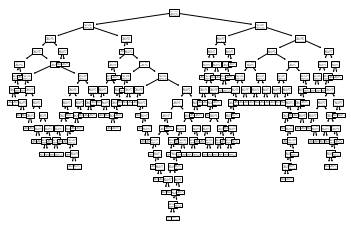

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import tree
tree.plot_tree(dt_clf) 

In [37]:
_data = tree.export_graphviz(dt_clf, out_file="None", filled=True, rounded=True,special_characters=True)

In [40]:
import graphviz 
from graphviz import Source
_data = tree.export_graphviz(dt_clf, out_file=None)
graph = graphviz.Source(_data) 
graph.render("name of file",view = True)
import pydotplus
from IPython.display import Image 

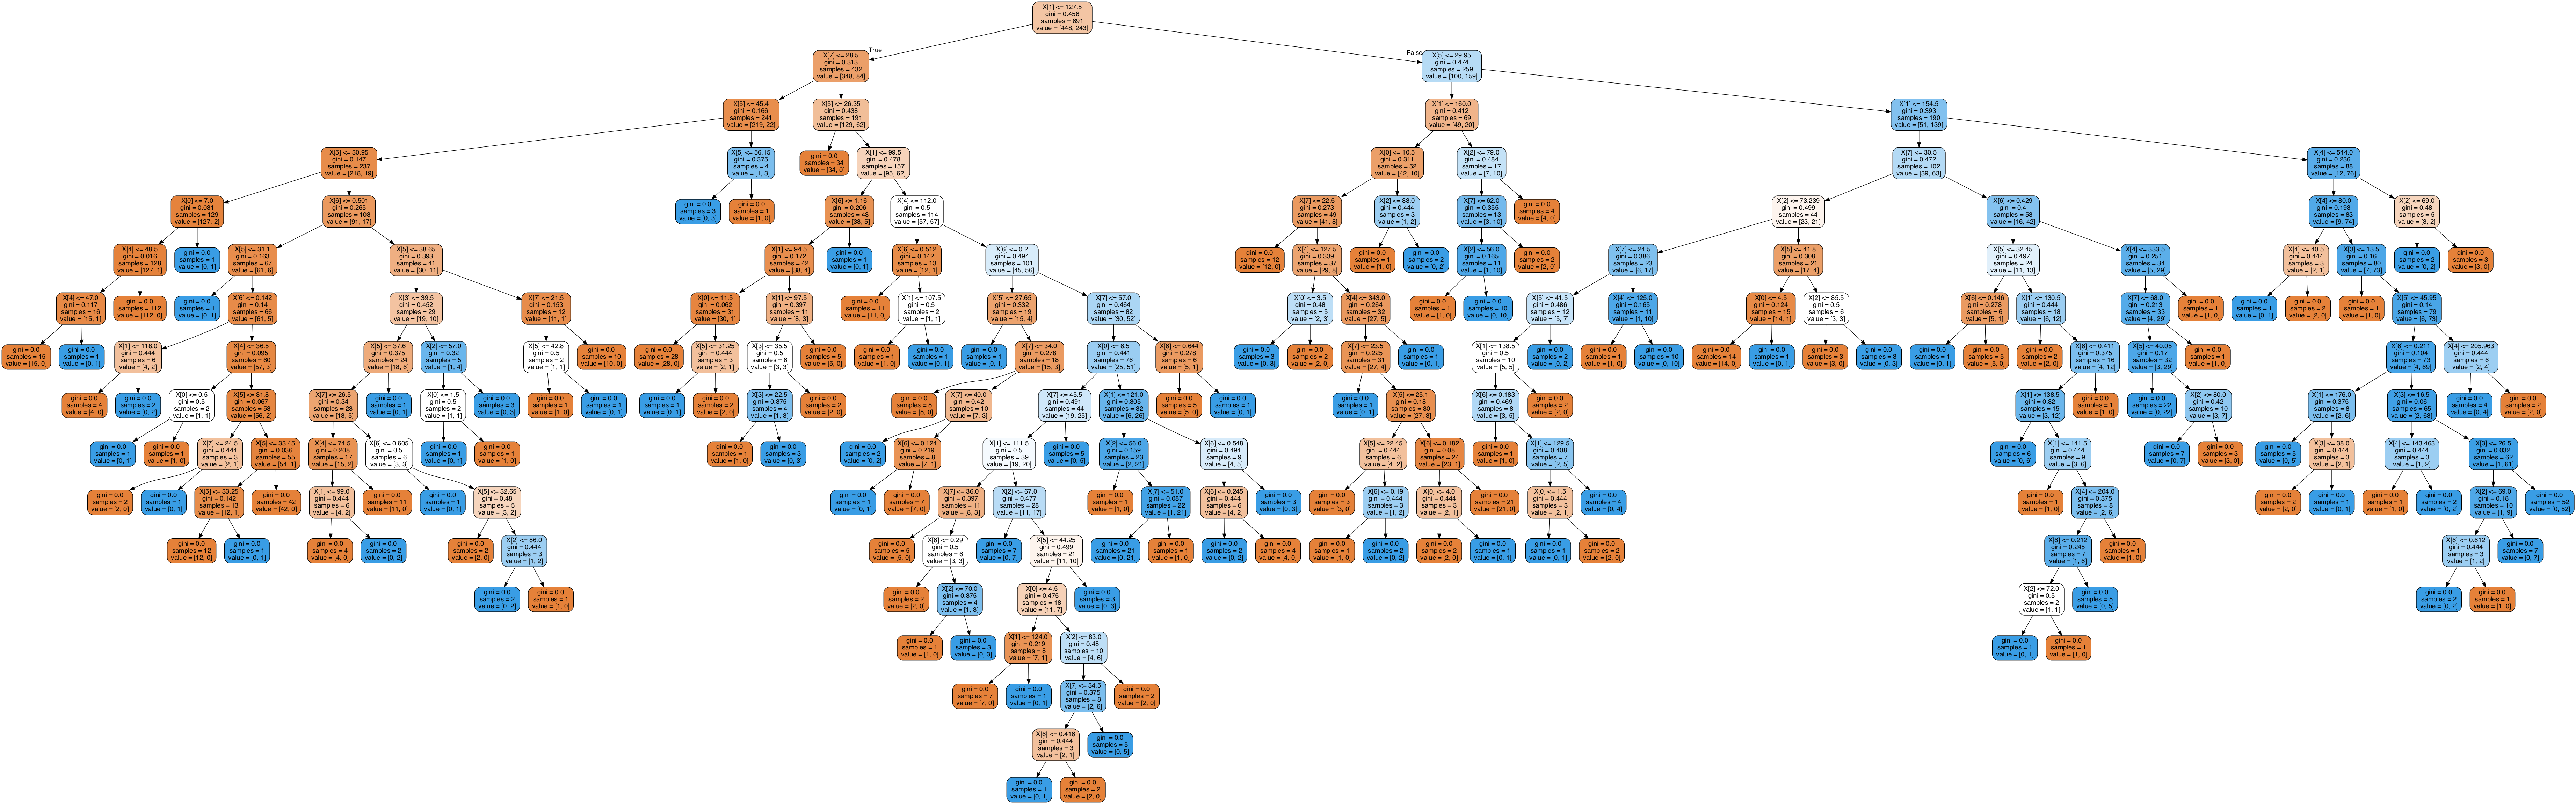

In [41]:
import pydotplus
_data = tree.export_graphviz(dt_clf, out_file=None, filled=True, rounded=True)

graph = pydotplus.graph_from_dot_data(_data)  

Image(graph.create_png())

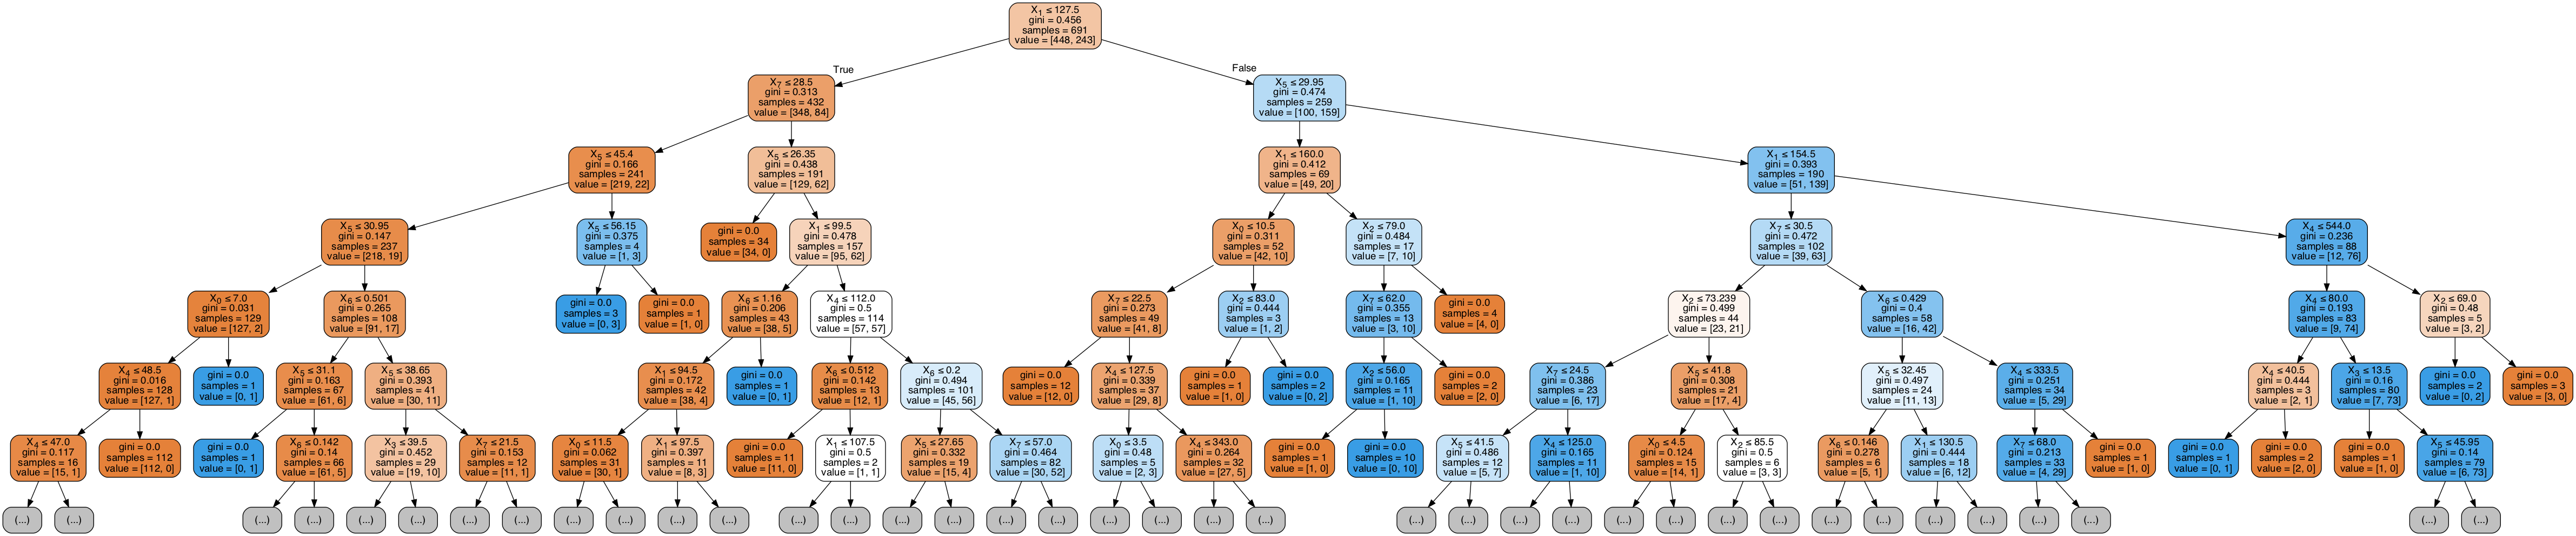

In [42]:
import pydotplus
_data = tree.export_graphviz(dt_clf, out_file=None, filled=True, rounded=True,
                special_characters=True, max_depth=6)

graph = pydotplus.graph_from_dot_data(_data)  


Image(graph.create_png())

# Test

## No missing values

accuracy 0.8292682926829268
AUC 0.8060344827586207


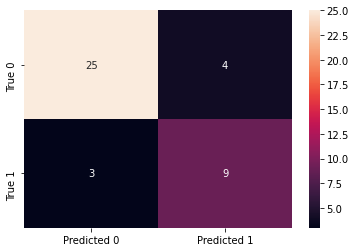

In [22]:
test = pd.read_csv('input/Test.csv')
test.dropna(inplace = True)
truth = test['Outcome']
test.drop('Outcome', axis = 1, inplace = True)
predictions = pipeline.predict(test)
conf = (confusion_matrix(truth,predictions))
acc = (accuracy_score(truth,predictions))
auc = (roc_auc_score(truth,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)  
print("accuracy", acc)
print("AUC", auc)
#plt.savefig('test_conf.eps', format='eps', dpi=1000)

Eureka, this is really good. 

## Missing values

accuracy 0.7922077922077922
AUC 0.7734615384615384


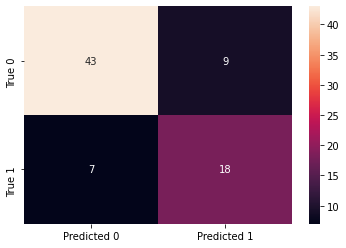

In [23]:
test = pd.read_csv('input/Test.csv')
truth = test['Outcome']
test.drop('Outcome', axis = 1, inplace = True)
predictions = pipeline.predict(test)
conf = (confusion_matrix(truth,predictions))
acc = (accuracy_score(truth,predictions))
auc = (roc_auc_score(truth,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)  
print("accuracy", acc)
print("AUC", auc)

Not as good, but still good.